In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import zipfile
from PIL import Image
import cv2


### Path to zip folder
zip_path = "C:/Users/Sven Jacob/Downloads/DAVIS-data.zip"

FPS_DAVIS = 24

file = 'cows'

with zipfile.ZipFile(zip_path, 'r') as zip_file:
    file_names = zip_file.namelist()
    png_files = [f for f in file_names if f.startswith("DAVIS/JPEGImages/480p/"+file) and f.lower().endswith(".jpg")]
    png_files = np.sort(png_files)
    frames = []
    for png in png_files:
        with zip_file.open(png) as file:
            image_bytes = file.read()
            image_array = np.frombuffer(image_bytes, dtype=np.uint8)
            image = cv2.imdecode(image_array, cv2.IMREAD_GRAYSCALE)
            frames.append(image)

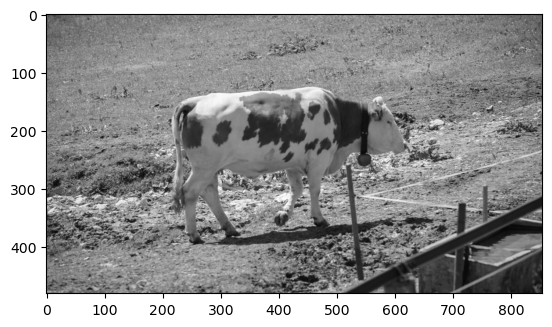

In [3]:
plt.imshow(frames[0],cmap='gray')

In [ ]:

def get_frame_size(frame):
    #width height
    return (frame.shape[1],frame.shape[0])

def video_from_images(images, 
                      video_name = 'video.avi',
                      FPS=1,
                      codec = cv2.VideoWriter_fourcc(*'MJPG')):
    print(images[0])
   
    frames_per_second = FPS
    frame_size = get_frame_size(images[0])

    video = cv2.VideoWriter(video_name, 
                            codec, 
                            frames_per_second, 
                            frame_size,isColor=False)  
    
    for image in images:
        
        if len(image.shape) == 2:  
            image = image #cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
            
        
        if get_frame_size(image) != frame_size:
            print(f"Warning: Resizing frame from {get_frame_size(image)} to {frame_size}")
            image = cv2.resize(image, frame_size)

        video.write(image.astype(np.uint8)) 

    video.release()
    print(f"Video saved as {video_name}")
video_from_images(frames, 'cows.avi',FPS=24)

[[106 101  92 ...  82  87 102]
 [104  95  90 ...  89  88  97]
 [ 94  91  99 ...  94  90  92]
 ...
 [139 167 174 ...  45  40  38]
 [111 145 159 ...  45  45  44]
 [111 128 132 ...  46  48  46]]
Video saved as cows.avi


In [4]:
M = np.vstack([f.flatten() for f in frames])
M.shape
##rows --> frames ,cols --> pixels

(104, 409920)

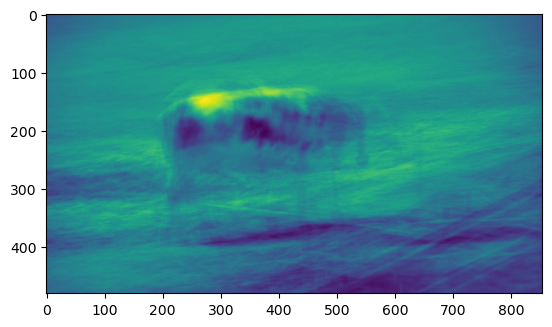

In [6]:
U,s,Vt = np.linalg.svd(M,full_matrices=False)
L=1

S_truncated = np.zeros_like(s)
S_truncated[:L] = s[:L]

M_background = U @ np.diag(S_truncated) @ Vt 
background_frames = M_background.reshape((-1, frames[0].shape[0],frames[0].shape[1]))
plt.imshow(background_frames[30])

In [14]:
from pydmd import DMD
from pydmd.plotter import plot_summary

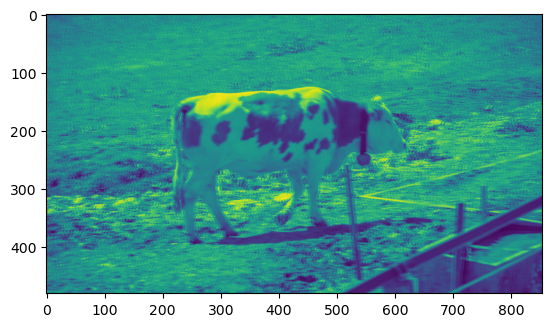

In [42]:
X = M.T.copy()

# window_size = 10
# for i in range(n_frames - window_size + 1):
#     X_window = X[:, i:i + window_size]  # Extract a window of frames
#     dmd = DMD(svd_rank=20)  # Re-initialize DMD
#     dmd.fit(X_window)

dmd = DMD(svd_rank=1)  # Re-initialize DMD

dmd.fit(X[:,:3])


plt.imshow(dmd.reconstructed_data[:,0].real.reshape(frames[0].shape[0],frames[0].shape[1]))

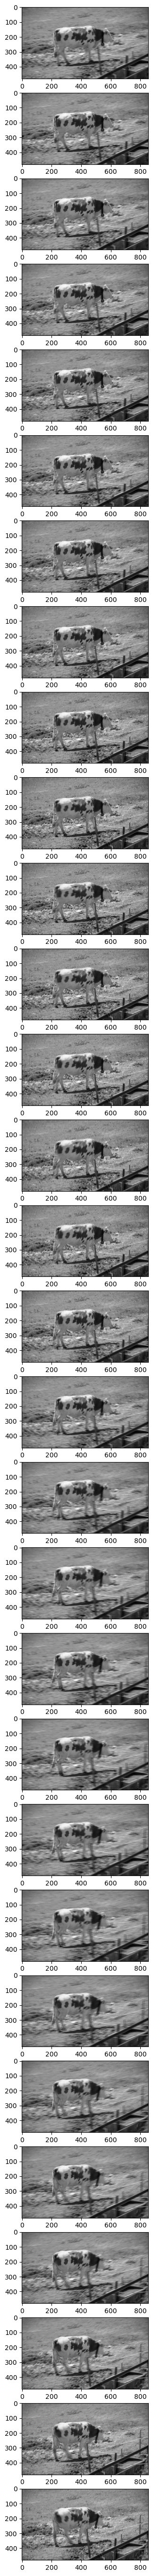

In [68]:
window_size = 5
fig, ax = plt.subplots(30,1,figsize=(5,70))
for i in range(30):
    X_window = X[:, i:i + window_size]  # Extract a window of frames
    dmd = DMD(svd_rank=1)  # Re-initialize DMD
    dmd.fit(X_window)
    ax[i].imshow(dmd.predict(X[:,i+10]).reshape(-1,1).reshape(frames[0].shape[0],frames[0].shape[1]).real,cmap='gray')